In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import os
from scipy.stats import chi2_contingency
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, Layer, Multiply, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

print("All imports successful.")

2026-02-24 11:36:43.889473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771933004.119814      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771933004.184462      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771933004.723165      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771933004.723202      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771933004.723204      55 computation_placer.cc:177] computation placer alr

All imports successful.


In [2]:
# All model artifacts will save here 
SAVE_PATH = '/kaggle/working/'

# confirm tf vesion and local gpu
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))
print("Save path:", SAVE_PATH)

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Save path: /kaggle/working/


In [3]:
BASE_PATH = '/kaggle/input/datasets/anlgrbz/student-demographics-online-education-dataoulad/'

print("Loading OULAD tables...")

# student submissions with scores
student_assessment = pd.read_csv(BASE_PATH + 'studentAssessment.csv')

# one per assignment, contains deadlines
assessments        = pd.read_csv(BASE_PATH + 'assessments.csv')

# one per student-course enrollment
student_info       = pd.read_csv(BASE_PATH + 'studentInfo.csv')

print(f"student_assessment: {len(student_assessment):,} rows")
print(f"assessments:        {len(assessments):,} rows")
print(f"student_info:       {len(student_info):,} rows")
print(f"Unique students:    {student_info['id_student'].nunique():,}")

Loading OULAD tables...
student_assessment: 173,912 rows
assessments:        206 rows
student_info:       32,593 rows
Unique students:    28,785


In [4]:
student_assessment.head()  

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [5]:
assessments.head() 

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [6]:
student_info.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [7]:

# CELL B — MERGE AND LABEL CONSTRUCTION


# --- Step 1: Rename 'date' in assessments to 'deadline_day' for clarity ---
# 'date' in the assessments table = the deadline, in days since course start
assessments_clean = assessments.rename(columns={"date": "deadline_day"})

# --- Step 2: Merge studentAssessment with assessments on id_assessment ---
# This gives us date_submitted AND deadline_day in the same row
merged_assessments = pd.merge(
    student_assessment,
    assessments_clean[["id_assessment", "deadline_day", "weight", 
                        "code_module", "code_presentation"]],
    on="id_assessment",
    how="inner"
)

print(f"merged_assessments shape: {merged_assessments.shape}")
print(merged_assessments.head())


# --- Step 3: Drop rows where deadline_day is missing ---
# Some assessments have no deadline (e.g. open-ended tasks) — drop these
# because we can't compute late/on-time without a deadline
merged_assessments = merged_assessments.dropna(subset=["deadline_day", "date_submitted"])
print(f"After dropping missing deadlines: {merged_assessments.shape}")

# --- Step 4: Drop banked assessments ---
# is_banked=1 means the student used a previous attempt's score
# These aren't real submission events for this course — exclude them
merged_assessments = merged_assessments[merged_assessments["is_banked"] == 0]
print(f"After dropping banked assessments: {merged_assessments.shape}")

# --- Step 5: Create the binary label ---
# y = 1 if the student submitted AFTER the deadline (procrastinator)
# y = 0 if submitted on or before the deadline (on time)
# date_submitted, and deadline_day are both in days since course start
# so this comparison is valid — same unit, same reference point
merged_assessments["submitted_late"] = (
    merged_assessments["date_submitted"] > merged_assessments["deadline_day"]
).astype(int)

# --- Check positive rate ---
positive_rate = merged_assessments["submitted_late"].mean()
print(f"\nPositive rate (late submissions): {positive_rate:.3f} ({positive_rate*100:.1f}%)")
print("Expected: 20-30% based on literature (You, 2015; Akram et al., 2019)")
print(merged_assessments["submitted_late"].value_counts())


merged_assessments shape: (173912, 9)
   id_assessment  id_student  date_submitted  is_banked  score  deadline_day  \
0           1752       11391              18          0   78.0          19.0   
1           1752       28400              22          0   70.0          19.0   
2           1752       31604              17          0   72.0          19.0   
3           1752       32885              26          0   69.0          19.0   
4           1752       38053              19          0   79.0          19.0   

   weight code_module code_presentation  
0    10.0         AAA             2013J  
1    10.0         AAA             2013J  
2    10.0         AAA             2013J  
3    10.0         AAA             2013J  
4    10.0         AAA             2013J  
After dropping missing deadlines: (171047, 9)
After dropping banked assessments: (169138, 9)

Positive rate (late submissions): 0.292 (29.2%)
Expected: 20-30% based on literature (You, 2015; Akram et al., 2019)
submitted_late
0  

In [8]:
merged_assessments.head()

,id_assessment,id_student,date_submitted,is_banked,score,deadline_day,weight,code_module,code_presentation,submitted_late
0,1752,11391,18,0,78.0,19.0,10.0,AAA,2013J,0
1,1752,28400,22,0,70.0,19.0,10.0,AAA,2013J,1
2,1752,31604,17,0,72.0,19.0,10.0,AAA,2013J,0
3,1752,32885,26,0,69.0,19.0,10.0,AAA,2013J,1
4,1752,38053,19,0,79.0,19.0,10.0,AAA,2013J,0


In [9]:
#  LABEL VALIDATION
# Consensus review recommends validating procrastination labels by checking
# they correlate with worse outcomes (lower grades, withdrawal).
# We check: do late submitters have worse final_result in OULAD?
# This is one cell — gives our label construction academic credibility.


# Merge with studentInfo to get final_result
merged_assessments_with_result = pd.merge(
    merged_assessments,
    student_info[["id_student", "final_result"]],
    on="id_student",
    how="left"
)

print(f"merged_assessments_with_result: {merged_assessments_with_result.head()}\n")


# Count late submissions per student
student_late_rate = merged_assessments_with_result.groupby("id_student").agg(
    late_rate=("submitted_late", "mean"),
    final_result=("final_result", "first")
).reset_index()


# Binary: procrastinator if late rate > 0.3 (submitted late >30% of the time)
student_late_rate["is_procrastinator"] = (
    student_late_rate["late_rate"] > 0.3
).astype(int)

# Binary outcome: did they fail or withdraw?
student_late_rate["poor_outcome"] = (
    student_late_rate["final_result"].isin(["Fail", "Withdrawn"])
).astype(int)

print(student_late_rate.head())

# Chi-square test: are procrastinators more likely to have poor outcomes?
contingency = pd.crosstab(
    student_late_rate["is_procrastinator"],
    student_late_rate["poor_outcome"]
)
chi2, p_value, dof, expected = chi2_contingency(contingency)

print("=== LABEL VALIDATION ===")
print(f"Chi-square: {chi2:.2f}, p-value: {p_value:.6f}")
print(f"Degrees of freedom: {dof}")
print("\nContingency table (procrastinator vs poor outcome):")
print(contingency)

if p_value < 0.05:
    print("\n✓ Label validated: late submitters significantly more likely to Fail/Withdraw")
    print("  This confirms submitted_late is a valid procrastination proxy.")
else:
    print("\n✗ No significant association — review label threshold")

# Distribution of late rates by final result
print("\n--- Mean late submission rate by final result ---")
print(student_late_rate.groupby("final_result")["late_rate"].mean().sort_values(ascending=False))

merged_assessments_with_result:    id_assessment  id_student  date_submitted  is_banked  score  deadline_day  \
0           1752       11391              18          0   78.0          19.0   
1           1752       28400              22          0   70.0          19.0   
2           1752       31604              17          0   72.0          19.0   
3           1752       32885              26          0   69.0          19.0   
4           1752       38053              19          0   79.0          19.0   

   weight code_module code_presentation  submitted_late final_result  
0    10.0         AAA             2013J               0         Pass  
1    10.0         AAA             2013J               1         Pass  
2    10.0         AAA             2013J               0         Pass  
3    10.0         AAA             2013J               1         Pass  
4    10.0         AAA             2013J               0         Pass  

   id_student  late_rate final_result  is_procrastinator  po

In [10]:

# DATASET OVERVIEW
# Just getting familiar with the data before touching the model.


print(f"Student-assessment pairs : {len(merged_assessments):,}")
print(f"Unique students          : {merged_assessments['id_student'].nunique():,}")
print(f"Unique assessments       : {merged_assessments['id_assessment'].nunique():,}")
print(f"Modules                  : {merged_assessments['code_module'].nunique()}")
print(f"Presentations            : {merged_assessments['code_presentation'].nunique()}")
print(f"\ndate_submitted range     : {merged_assessments['date_submitted'].min()} to {merged_assessments['date_submitted'].max()} days")
print(f"deadline_day range       : {merged_assessments['deadline_day'].min()} to {merged_assessments['deadline_day'].max()} days")
print(f"\nNegative submissions (submissions made before course start): {(merged_assessments['date_submitted'] < 0).sum():,}")
print(f"Missing scores                          : {merged_assessments['score'].isna().sum():,}")

print(f"\nFinal result distribution (from studentInfo):")
print(student_info["final_result"].value_counts().to_string())

Student-assessment pairs : 169,138
Unique students          : 23,309
Unique assessments       : 185
Modules                  : 7
Presentations            : 4

date_submitted range     : -11 to 608 days
deadline_day range       : 12.0 to 261.0 days

Negative submissions (submissions made before course start): 148
Missing scores                          : 172

Final result distribution (from studentInfo):
final_result
Pass           12361
Withdrawn      10156
Fail            7052
Distinction     3024


LABEL DISTRIBUTION

 Overall LATE: 0.29

Late submission rate: 29.16%
On time: 119,820
Late:    49,318

✓  In expected range. Class weights are sufficient.

Late rate by module: 10% – 66%
>20pp spread across modules — note as limitation.


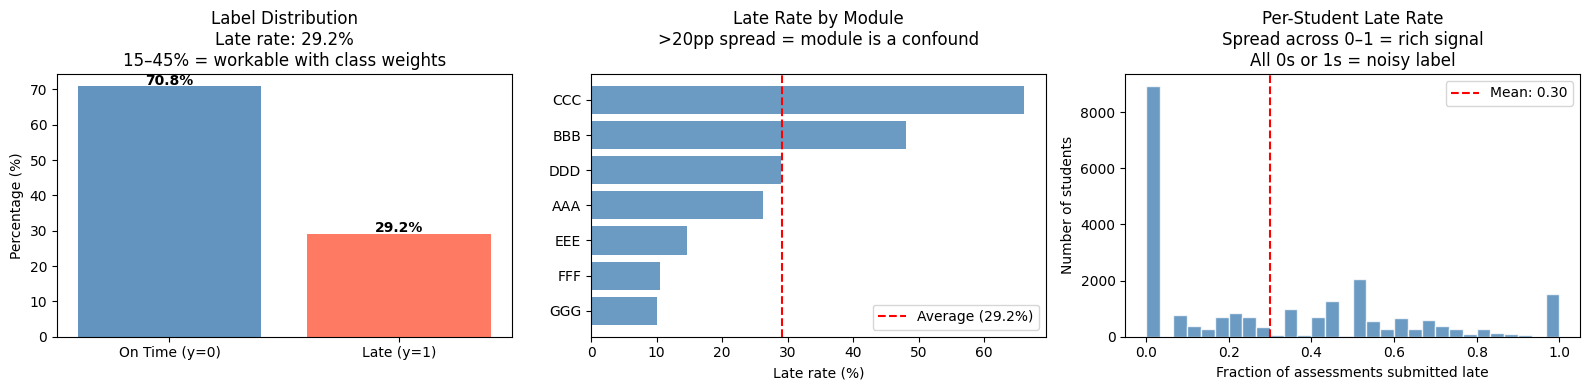

In [11]:

# EDA CELL 2 — LABEL DISTRIBUTION
# MODEL DECISION: Is the positive rate workable with class weights,
# or do we need a different strategy?
#
# WHAT TO LOOK FOR:
# → 15–45%: healthy. Class weights are sufficient. Proceed as planned.
# → < 15%: severe imbalance. Also tune decision threshold at inference
#           (use 0.35 instead of 0.5 as cutoff).
# → > 45%: double-check label logic — may have a bug in the comparison.


print("LABEL DISTRIBUTION")

overall_late = merged_assessments["submitted_late"].mean() # fraction of late to not late
print(f"\n Overall LATE: {overall_late:.2f}\n")
print(f"Late submission rate: {overall_late*100:.2f}%")
print(f"On time: {(merged_assessments['submitted_late']==0).sum():,}")
print(f"Late:    {(merged_assessments['submitted_late']==1).sum():,}")

if overall_late < 0.15:
    print("\n  < 15%: also tune decision threshold to 0.35 at inference.")
elif overall_late > 0.45:
    print("\n  > 45%: verify label construction — check deadline_day units.")
else:
    print("\n✓  In expected range. Class weights are sufficient.")

# Late rate by module (check for confounding)
module_late = merged_assessments.groupby("code_module")["submitted_late"].mean()
print(f"\nLate rate by module: {module_late.min()*100:.0f}% – {module_late.max()*100:.0f}%")
if module_late.max() - module_late.min() > 0.20:
    print(">20pp spread across modules — note as limitation.")

# Per-student late rate
student_late = merged_assessments.groupby("id_student")["submitted_late"].mean()

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Overall counts
axes[0].bar(["On Time (y=0)", "Late (y=1)"],
            [(1 - overall_late) * 100, overall_late * 100],
            color=["steelblue", "tomato"], alpha=0.85)
axes[0].set_title(f"Label Distribution\nLate rate: {overall_late*100:.1f}%\n"
                   "15–45% = workable with class weights")
axes[0].set_ylabel("Percentage (%)")
for i, v in enumerate([(1 - overall_late) * 100, overall_late * 100]):
    axes[0].text(i, v + 0.5, f"{v:.1f}%", ha="center", fontweight="bold")

# By module
axes[1].barh(module_late.sort_values().index,
             module_late.sort_values().values * 100,
             color="steelblue", alpha=0.8)
axes[1].axvline(overall_late * 100, color="red", linestyle="--",
                label=f"Average ({overall_late*100:.1f}%)")
axes[1].set_title("Late Rate by Module\n"
                   ">20pp spread = module is a confound\n")
axes[1].set_xlabel("Late rate (%)")
axes[1].legend()

# Per-student distribution
axes[2].hist(student_late, bins=30, color="steelblue", alpha=0.8, edgecolor="white")
axes[2].axvline(student_late.mean(), color="red", linestyle="--",
                label=f"Mean: {student_late.mean():.2f}")
axes[2].set_title("Per-Student Late Rate\n"
                   "Spread across 0–1 = rich signal\n"
                   "All 0s or 1s = noisy label")
axes[2].set_xlabel("Fraction of assessments submitted late")
axes[2].set_ylabel("Number of students")
axes[2].legend()

plt.tight_layout()
plt.savefig("eda_02_labels.png", dpi=150, bbox_inches="tight")
plt.show()

 — SEQUENCE LENGTH DISTRIBUTION
Min:    1
Max:    27
Mean:   7.3
Median: 7.0
  ≥4 assessments: 18,479 students (79.3%)
  ≥6 assessments: 13,675 students (58.7%)
  ≥8 assessments: 10,657 students (45.7%)
  ≥10 assessments: 7,925 students (34.0%)

  Median=7. Consider reducing window size to 6.


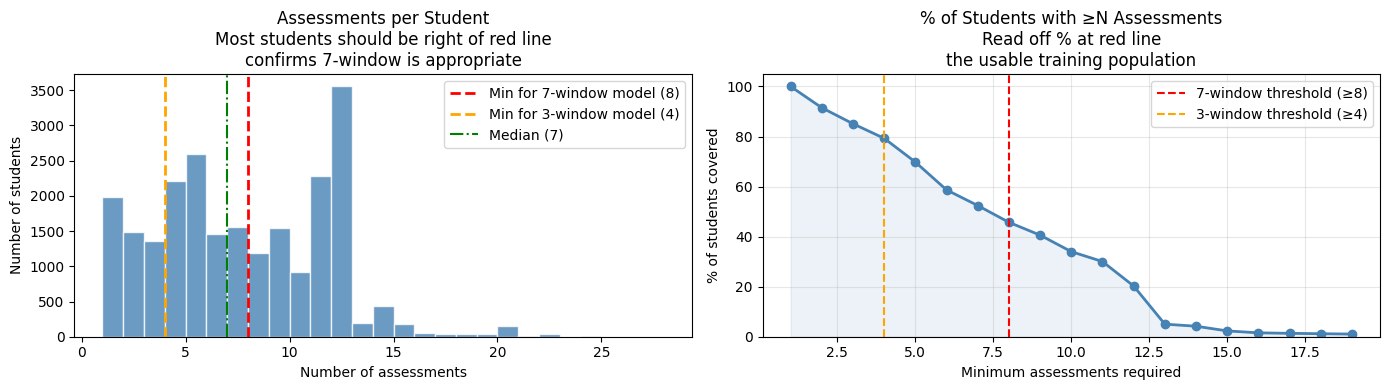

In [12]:

# EDA CELL 3 — ASSESSMENTS PER STUDENT (informs window size)

# MODEL DECISION: Is a window of 7 assessments valid for most students?
#
# WHAT TO LOOK FOR:
# → Median ≥ 8: window of 7 is correct — most students provide at least
#   one training sample for the main model.
# → Median 5–7: consider reducing the window to 5.
# → Where does the natural cluster sit? OULAD literature says ~8.
#   If you see a spike at exactly 8, your window of 7 is optimal.



print(" — SEQUENCE LENGTH DISTRIBUTION")


assessments_per_student = merged_assessments.groupby("id_student")["id_assessment"].count()
median_n = assessments_per_student.median()

print(f"Min:    {assessments_per_student.min()}")
print(f"Max:    {assessments_per_student.max()}")
print(f"Mean:   {assessments_per_student.mean():.1f}")
print(f"Median: {median_n:.1f}")

for min_n in [4, 6, 8, 10]:
    n = (assessments_per_student >= min_n).sum()
    pct = n / len(assessments_per_student) * 100
    print(f"  ≥{min_n} assessments: {n:,} students ({pct:.1f}%)")

if median_n >= 8:
    print(f"\n  Median={median_n:.0f}. Window size 7 confirmed.")
else:
    print(f"\n  Median={median_n:.0f}. Consider reducing window size to {int(median_n)-1}.")

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(assessments_per_student,
             bins=range(1, min(30, assessments_per_student.max() + 2)),
             color="steelblue", alpha=0.8, edgecolor="white")
axes[0].axvline(8, color="red", linestyle="--", linewidth=2,
                label="Min for 7-window model (8)")
axes[0].axvline(4, color="orange", linestyle="--", linewidth=2,
                label="Min for 3-window model (4)")
axes[0].axvline(median_n, color="green", linestyle="-.",
                label=f"Median ({median_n:.0f})")
axes[0].set_title("Assessments per Student\n"
                   "Most students should be right of red line\n"
                   "confirms 7-window is appropriate")
axes[0].set_xlabel("Number of assessments")
axes[0].set_ylabel("Number of students")
axes[0].legend()

# Cumulative coverage
thresholds = range(1, min(20, assessments_per_student.max() + 1))
coverage = [(assessments_per_student >= t).mean() * 100 for t in thresholds]
axes[1].plot(list(thresholds), coverage, "o-", color="steelblue", linewidth=2)
axes[1].axvline(8, color="red",    linestyle="--", label="7-window threshold (≥8)")
axes[1].axvline(4, color="orange", linestyle="--", label="3-window threshold (≥4)")
axes[1].fill_between(list(thresholds), coverage, alpha=0.1, color="steelblue")
axes[1].set_title("% of Students with ≥N Assessments\n"
                   "Read off % at red line\n"
                   "the usable training population")
axes[1].set_xlabel("Minimum assessments required")
axes[1].set_ylabel("% of students covered")
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 105)

plt.tight_layout()
plt.savefig("eda_03_sequence_lengths.png", dpi=150, bbox_inches="tight")
plt.show()

TEMPORAL AUTOCORRELATION
P(late | previous was late):    0.386 (38.6%)
P(late | previous was on time): 0.261 (26.1%)
Autocorrelation ratio:          1.48×

—  Moderate autocorrelation (1.48×). LSTM valid, temper performance claims.


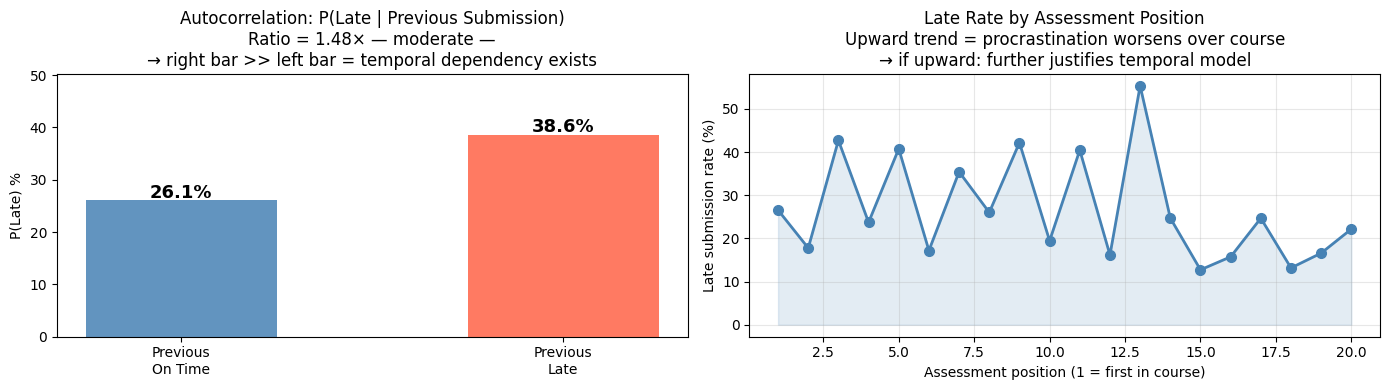

In [13]:
# TEMPORAL AUTOCORRELATION (most important cell)
# MODEL DECISION: does temporal structure exist in the data?
# If yes → LSTM is justified over static classifiers.
# This is the single number you quote in your write-up to justify Bi-LSTM.
# WHAT TO LOOK FOR:
# → Ratio > 1.5×: strong temporal dependency. LSTM is fully justified.
#   Quote: "The X× autocorrelation ratio confirms temporal dependency,
#   justifying Bi-LSTM over static classifiers (SVM baseline)."
# → Ratio 1.2–1.5×: moderate. LSTM is still valid, just temper claims.
# → Ratio < 1.2×: weak. Be honest — LSTM advantage may be modest.
#   Lean into methodological novelty rather than performance claims.

print("TEMPORAL AUTOCORRELATION")


merged_assessments_sorted_eda = merged_assessments.sort_values(["id_student", "deadline_day"])
merged_assessments_sorted_eda["prev_late"] = (
    merged_assessments_sorted_eda.groupby("id_student")["submitted_late"].shift(1)
)
autocorr_df = merged_assessments_sorted_eda.dropna(subset=["prev_late"])

p_late_prev_late   = autocorr_df[autocorr_df["prev_late"] == 1]["submitted_late"].mean()
p_late_prev_ontime = autocorr_df[autocorr_df["prev_late"] == 0]["submitted_late"].mean()
ratio = p_late_prev_late / p_late_prev_ontime if p_late_prev_ontime > 0 else 0

# Late rate by position
merged_assessments_sorted_eda["position"] = merged_assessments_sorted_eda.groupby("id_student").cumcount() + 1
late_by_pos = (merged_assessments_sorted_eda.groupby("position")["submitted_late"]
               .agg(["mean", "count"]).reset_index())
late_by_pos = late_by_pos[late_by_pos["count"] >= 200]

print(f"P(late | previous was late):    {p_late_prev_late:.3f} ({p_late_prev_late*100:.1f}%)")
print(f"P(late | previous was on time): {p_late_prev_ontime:.3f} ({p_late_prev_ontime*100:.1f}%)")
print(f"Autocorrelation ratio:          {ratio:.2f}×")

if ratio > 1.5:
    print(f"\n✓  LSTM JUSTIFIED ({ratio:.2f}×)")
    print(f"   Quote in write-up: 'The {ratio:.2f}× autocorrelation ratio confirms")
    print(f"   temporal dependency in procrastination behaviour, justifying")
    print(f"   Bi-LSTM over the static SVM baseline.'")
elif ratio > 1.2:
    print(f"\n—  Moderate autocorrelation ({ratio:.2f}×). LSTM valid, temper performance claims.")
else:
    print(f"\n  Weak autocorrelation ({ratio:.2f}×). Emphasise methodological novelty.")

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Autocorrelation bar
axes[0].bar(["Previous\nOn Time", "Previous\nLate"],
            [p_late_prev_ontime * 100, p_late_prev_late * 100],
            color=["steelblue", "tomato"], alpha=0.85, width=0.5)
axes[0].set_title(f"Autocorrelation: P(Late | Previous Submission)\n"
                   f"Ratio = {ratio:.2f}× — "
                   f"{'LSTM justified ✓' if ratio > 1.5 else 'moderate —'}\n"
                   f"→ right bar >> left bar = temporal dependency exists")
axes[0].set_ylabel("P(Late) %")
axes[0].set_ylim(0, max(p_late_prev_late * 100 * 1.3, 30))
for i, v in enumerate([p_late_prev_ontime * 100, p_late_prev_late * 100]):
    axes[0].text(i, v + 0.5, f"{v:.1f}%", ha="center", fontweight="bold", fontsize=13)

# Late rate by position
axes[1].plot(late_by_pos["position"], late_by_pos["mean"] * 100,
             "o-", color="steelblue", linewidth=2, markersize=7)
axes[1].fill_between(late_by_pos["position"],
                     late_by_pos["mean"] * 100, alpha=0.15, color="steelblue")
axes[1].set_title("Late Rate by Assessment Position\n"
                   "Upward trend = procrastination worsens over course\n"
                   "→ if upward: further justifies temporal model")
axes[1].set_xlabel("Assessment position (1 = first in course)")
axes[1].set_ylabel("Late submission rate (%)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("eda_04_autocorrelation.png", dpi=150, bbox_inches="tight")
plt.show()

EDA CELL 5 — FEATURE CLASS SEPARATION


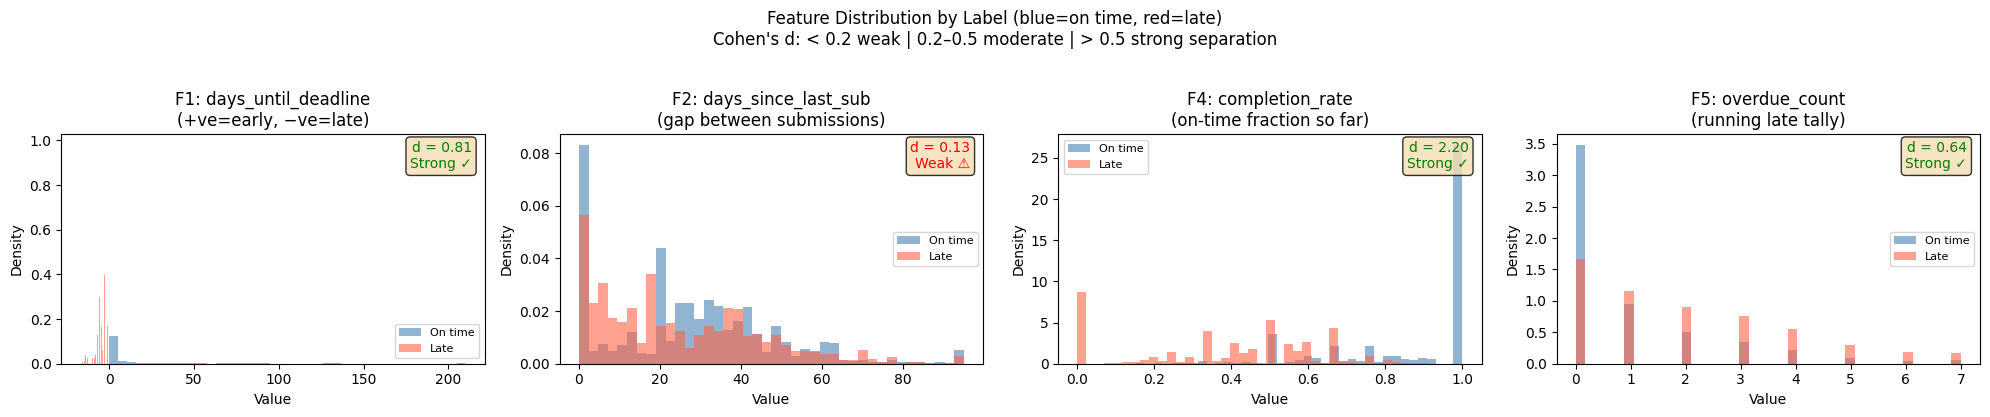

Cohen's d summary:
  f1_days_until_deadline         d = 0.814  Strong ✓
  f2_days_since_last_sub         d = 0.132  Weak ⚠️
  f4_completion_rate             d = 2.200  Strong ✓
  f5_overdue_count               d = 0.638  Strong ✓

Expectation: days_until_deadline should be strongest (Imhof et al. 2021).
If attention weights (Cell N) disagree with this, investigate.


In [14]:

# EDA CELL 5 — FEATURE CLASS SEPARATION (Cohen's d)

# MODEL DECISION: which features carry the most signal?
# Sets expectations before training — attention weights (Cell N) should
# confirm whatever is strong here.
#
# WHAT TO LOOK FOR:
# → days_until_deadline: should be STRONGEST (Imhof et al. 2021).
#   If it's not, review label construction.
# → Cohen's d > 0.5: strong — model will pick this up easily.
# → Cohen's d < 0.2: weak — feature may not contribute much.
#   Keep it — LSTM can find nonlinear patterns Pearson r misses —
#   but note in limitations if it's very weak.



print("EDA CELL 5 — FEATURE CLASS SEPARATION")


# Compute flat features for visualisation
merged_assessments_feat = merged_assessments.sort_values(["id_student", "deadline_day"]).copy()
merged_assessments_feat["f1_days_until_deadline"] = (
    merged_assessments_feat["deadline_day"] - merged_assessments_feat["date_submitted"]
)
merged_assessments_feat["f2_days_since_last_sub"] = (
    merged_assessments_feat.groupby("id_student")["date_submitted"]
    .diff().fillna(merged_assessments_feat["deadline_day"]).clip(lower=0)
)
merged_assessments_feat["cum_ontime"] = (
    merged_assessments_feat.groupby("id_student")
    ["submitted_late"].transform(lambda x: (x == 0).cumsum())
)
merged_assessments_feat["assess_num"] = merged_assessments_feat.groupby("id_student").cumcount() + 1
merged_assessments_feat["f4_completion_rate"] = merged_assessments_feat["cum_ontime"] / merged_assessments_feat["assess_num"]
merged_assessments_feat["cum_late"] = (
    merged_assessments_feat.groupby("id_student")["submitted_late"].cumsum()
)
merged_assessments_feat["f5_overdue_count"] = merged_assessments_feat["cum_late"] - merged_assessments_feat["submitted_late"]

features = [
    ("f1_days_until_deadline", "F1: days_until_deadline\n(+ve=early, −ve=late)"),
    ("f2_days_since_last_sub", "F2: days_since_last_sub\n(gap between submissions)"),
    ("f4_completion_rate",     "F4: completion_rate\n(on-time fraction so far)"),
    ("f5_overdue_count",       "F5: overdue_count\n(running late tally)"),
]

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
cohen_d_results = {}

for i, (col, label) in enumerate(features):
    data   = merged_assessments_feat[col].dropna()
    p1, p99 = data.quantile(0.01), data.quantile(0.99)
    on_t   = merged_assessments_feat[merged_assessments_feat["submitted_late"] == 0][col].dropna().clip(p1, p99)
    late   = merged_assessments_feat[merged_assessments_feat["submitted_late"] == 1][col].dropna().clip(p1, p99)

    pooled = np.sqrt((on_t.std()**2 + late.std()**2) / 2)
    cd     = abs(on_t.mean() - late.mean()) / pooled if pooled > 0 else 0
    cohen_d_results[col] = cd

    axes[i].hist(on_t,  bins=40, alpha=0.6, color="steelblue",
                 label="On time", density=True)
    axes[i].hist(late,  bins=40, alpha=0.6, color="tomato",
                 label="Late",    density=True)
    axes[i].set_title(label)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Density")
    axes[i].legend(fontsize=8)

    cd_color = "green" if cd > 0.5 else ("orange" if cd > 0.2 else "red")
    cd_txt   = "Strong ✓" if cd > 0.5 else ("Moderate —" if cd > 0.2 else "Weak ⚠️")
    axes[i].text(0.97, 0.97, f"d = {cd:.2f}\n{cd_txt}",
                 transform=axes[i].transAxes, ha="right", va="top",
                 color=cd_color, fontsize=10,
                 bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8))

plt.suptitle("Feature Distribution by Label (blue=on time, red=late)\n"
             "Cohen's d: < 0.2 weak | 0.2–0.5 moderate | > 0.5 strong separation",
             fontsize=12, y=1.03)
plt.tight_layout()
plt.savefig("eda_05_features.png", dpi=150, bbox_inches="tight")
plt.show()

print("Cohen's d summary:")
for col, cd in cohen_d_results.items():
    verdict = "Strong ✓" if cd > 0.5 else ("Moderate —" if cd > 0.2 else "Weak ⚠️")
    print(f"  {col:<30} d = {cd:.3f}  {verdict}")

print("\nExpectation: days_until_deadline should be strongest (Imhof et al. 2021).")
print("If attention weights (Cell N) disagree with this, investigate.")

EDA CELL 6 — CORRELATION HEATMAP
Correlation matrix:
                     days_until_deadline  days_since_last_sub  \
days_until_deadline                1.000               -0.164   
days_since_last_sub               -0.164                1.000   
completion_rate                    0.268                0.114   
overdue_count                     -0.116               -0.183   
LABEL                             -0.299               -0.056   

                     completion_rate  overdue_count  LABEL  
days_until_deadline            0.268         -0.116 -0.299  
days_since_last_sub            0.114         -0.183 -0.056  
completion_rate                1.000         -0.551 -0.723  
overdue_count                 -0.551          1.000  0.286  
LABEL                         -0.723          0.286  1.000  

Multicollinearity between input features:
  ✓  No problematic multicollinearity found.

Feature-label correlations:
  days_until_deadline            r = -0.299  Moderate
  days_since_last_s

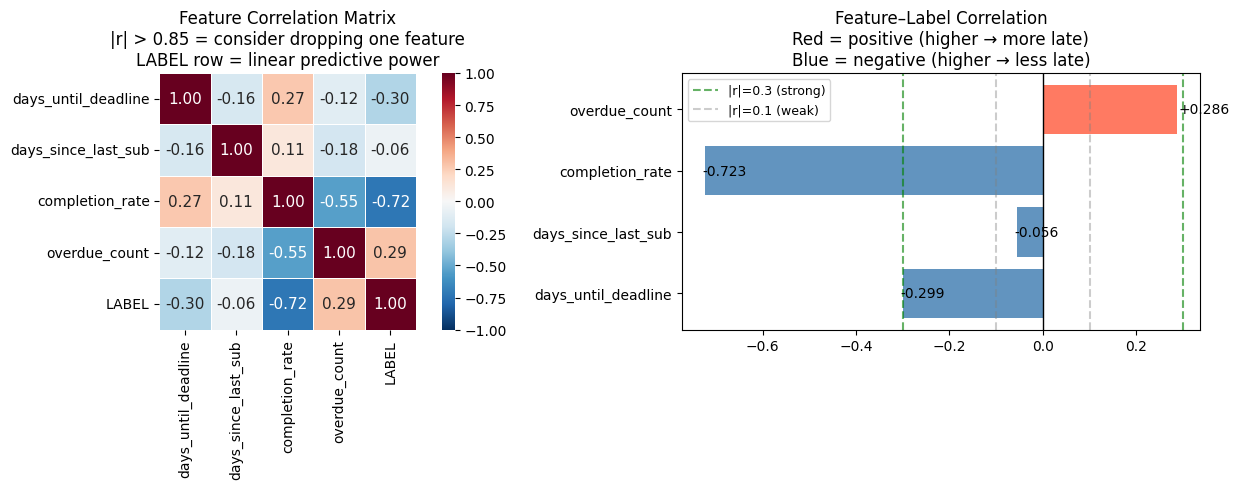

In [15]:

# EDA CELL 6 — FEATURE CORRELATION HEATMAP

# MODEL DECISION: are any features so correlated they're redundant?
# Also shows feature-label correlations — useful for discussion.
#
# WHAT TO LOOK FOR:
# → completion_rate ↔ overdue_count: expect strong negative correlation
#   (~−0.7 to −0.9). That's fine — they encode the same signal in
#   opposite directions. LSTM can use both.
# → |r| > 0.95 between two features: one may be redundant. Consider dropping.
# → Feature-label row (LABEL column): any |r| > 0.3 = strong linear predictor.
#   Weaker features may still help nonlinearly — the LSTM will decide.



print("EDA CELL 6 — CORRELATION HEATMAP")


corr_data = merged_assessments_feat[[
    "f1_days_until_deadline",
    "f2_days_since_last_sub",
    "f4_completion_rate",
    "f5_overdue_count",
    "submitted_late"
]].rename(columns={
    "f1_days_until_deadline": "days_until_deadline",
    "f2_days_since_last_sub": "days_since_last_sub",
    "f4_completion_rate":     "completion_rate",
    "f5_overdue_count":       "overdue_count",
    "submitted_late":         "LABEL"
}).dropna()

corr_matrix = corr_data.corr()

print("Correlation matrix:")
print(corr_matrix.round(3))

# Flag multicollinearity between input features
feat_names = ["days_until_deadline", "days_since_last_sub",
              "completion_rate", "overdue_count"]
print("\nMulticollinearity between input features:")
found_any = False
for i, f1 in enumerate(feat_names):
    for f2 in feat_names[i+1:]:
        r = corr_matrix.loc[f1, f2]
        if abs(r) > 0.85:
            print(f"  ⚠️  HIGH: {f1} ↔ {f2}: r={r:.3f} — consider dropping one")
            found_any = True
        elif abs(r) > 0.6:
            print(f"  —  Moderate: {f1} ↔ {f2}: r={r:.3f} — acceptable, keep both")
            found_any = True
if not found_any:
    print("  ✓  No problematic multicollinearity found.")

print("\nFeature-label correlations:")
for feat in feat_names:
    r = corr_matrix.loc[feat, "LABEL"]
    strength = "Strong" if abs(r) > 0.3 else ("Moderate" if abs(r) > 0.1 else "Weak")
    print(f"  {feat:<30} r = {r:+.3f}  {strength}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="RdBu_r",
            center=0, vmin=-1, vmax=1, ax=axes[0],
            square=True, linewidths=0.5, annot_kws={"size": 11})
axes[0].set_title("Feature Correlation Matrix\n"
                   "|r| > 0.85 = consider dropping one feature\n"
                   "LABEL row = linear predictive power")

# Feature-label bar
label_corr = corr_matrix["LABEL"].drop("LABEL")
colors = ["tomato" if r > 0 else "steelblue" for r in label_corr]
axes[1].barh(label_corr.index, label_corr.values, color=colors, alpha=0.85)
axes[1].axvline(0,    color="black", linewidth=1)
axes[1].axvline( 0.3, color="green", linestyle="--", alpha=0.6, label="|r|=0.3 (strong)")
axes[1].axvline(-0.3, color="green", linestyle="--", alpha=0.6)
axes[1].axvline( 0.1, color="gray",  linestyle="--", alpha=0.4, label="|r|=0.1 (weak)")
axes[1].axvline(-0.1, color="gray",  linestyle="--", alpha=0.4)
axes[1].set_title("Feature–Label Correlation\n"
                   "Red = positive (higher → more late)\n"
                   "Blue = negative (higher → less late)")
axes[1].legend(fontsize=9)
for feat, r in label_corr.items():
    axes[1].text(r + 0.005 * np.sign(r), feat, f"{r:+.3f}",
                 va="center", fontsize=10)

plt.tight_layout()
plt.savefig("eda_06_correlations.png", dpi=150, bbox_inches="tight")
plt.show()



In [16]:

# EDA SUMMARY — numbers to copy into your write-up


print("\n" + "=" * 55)
print("EDA SUMMARY — COPY THESE INTO YOUR WRITE-UP")

print(f"""
Dataset (Section 4.1):
  {merged_assessments['id_student'].nunique():,} students, {len(merged_assessments):,} assessment records
  {merged_assessments['code_module'].nunique()} modules, {merged_assessments['code_presentation'].nunique()} presentations
  Late submission rate: {merged_assessments['submitted_late'].mean()*100:.1f}%

Feature analysis (Section 4.2):
  Report Cohen's d values from EDA Cell 5.
  Strongest predictor should be days_until_deadline (Imhof et al. 2021).

Temporal justification for Bi-LSTM (Section 4.3):
  P(late | prev late):    {p_late_prev_late*100:.1f}%
  P(late | prev on time): {p_late_prev_ontime*100:.1f}%
  Ratio: {ratio:.2f}×

  → Write: "Late submission behaviour exhibited significant temporal
    autocorrelation (ratio = {ratio:.2f}×), confirming that a student's
    history of procrastination predicts future procrastination. This
    finding justifies the use of a sequential Bi-LSTM architecture
    over static classifiers such as SVM."

Saved plots:
  eda_02_labels.png         eda_03_sequence_lengths.png
  eda_04_autocorrelation.png eda_05_features.png
  eda_06_correlations.png
""")


EDA SUMMARY — COPY THESE INTO YOUR WRITE-UP

Dataset (Section 4.1):
  23,309 students, 169,138 assessment records
  7 modules, 4 presentations
  Late submission rate: 29.2%

Feature analysis (Section 4.2):
  Report Cohen's d values from EDA Cell 5.
  Strongest predictor should be days_until_deadline (Imhof et al. 2021).

Temporal justification for Bi-LSTM (Section 4.3):
  P(late | prev late):    38.6%
  P(late | prev on time): 26.1%
  Ratio: 1.48×

  → Write: "Late submission behaviour exhibited significant temporal
    autocorrelation (ratio = 1.48×), confirming that a student's
    history of procrastination predicts future procrastination. This
    finding justifies the use of a sequential Bi-LSTM architecture
    over static classifiers such as SVM."

Saved plots:
  eda_02_labels.png         eda_03_sequence_lengths.png
  eda_04_autocorrelation.png eda_05_features.png
  eda_06_correlations.png



In [17]:

# CELL D — MINIMUM PARTICIPATION FILTER

# Consensus preprocessing review: filter students with too few assessments
# to avoid noise. Minimum 3 assessments required.


# Count assessments per student
assessment_counts = merged_assessments.groupby("id_student")["id_assessment"].count()
qualified_students = assessment_counts[assessment_counts >= 3].index

print(f"Students before filter: {merged_assessments['id_student'].nunique()}")
merged_assessments = merged_assessments[merged_assessments["id_student"].isin(qualified_students)]
print(f"Students after filter (≥3 assessments): {merged_assessments['id_student'].nunique()}")

Students before filter: 23309
Students after filter (≥3 assessments): 19835


In [18]:

# SORT AND COMPUTE PER-STUDENT SEQUENTIAL FEATURES

# This is the heart of the pipeline.
# For each student, we sort their assessments chronologically (by deadline_day)
# and compute 5 features at each assessment point.
#
# WHY ASSESSMENT-LEVEL NOT DAILY:
# Each student has ~8 assessments across 270 days.
# If we built daily rows, most days would be zeros (sparse, uninformative).
# Assessment-level rows are DENSE — every row has real behavioural signal.
# This mirrors the platform: one bundle = one assessment = one sequence point.
#
# THE 5 FEATURES (all literature-grounded):
# 1. days_until_deadline: deadline_day - date_submitted
#    Negative = late. Positive = early. (Imhof et al. 2021 — strongest predictor)
# 2. days_since_last_submission: gap between consecutive submissions
#    Long gaps indicate inactivity. (Imhof block-click-interval analog)
# 3. submitted_today: 1 (always 1 at assessment rows — student submitted)
#    On platform this fires when a bundle closes with ≥1 task completed
# 4. completion_rate_so_far: assessments submitted on time / total so far
#    Running track record. (Yang et al. 2020, Akram et al. 2019)
# 5. overdue_count: running count of late submissions so far
#    Accumulating penalty signal. (Multiple papers)


def build_student_sequences(student_df):
    """
    Takes all assessment rows for ONE student, sorted by deadline_day.
    Returns a list of feature rows — one per assessment.
    Each row: [days_until_deadline, days_since_last_sub, 
                submitted_today, completion_rate_so_far, overdue_count]
    Plus the label for that assessment: submitted_late
    """
    # Sort assessments chronologically by deadline
    student_df = student_df.sort_values("deadline_day").reset_index(drop=True)
    
    rows = []
    overdue_count = 0        # running count of late submissions
    on_time_count = 0        # running count of on-time submissions
    prev_submission_day = None  # day of previous submission (for gap calculation)
    
    for i, row in student_df.iterrows():
        
        # Feature 1: days_until_deadline
        # Positive = submitted early, Negative = submitted late
        # This is the most predictive feature per Imhof et al. (2021)
        days_until_deadline = row["deadline_day"] - row["date_submitted"]
        
        # Feature 2: days_since_last_submission
        # First assessment: use deadline_day as proxy for course length so far
        # Subsequent assessments: gap between this and previous submission
        if prev_submission_day is None:
            days_since_last_sub = row["deadline_day"]  # approximate for first
        else:
            days_since_last_sub = row["date_submitted"] - prev_submission_day
            days_since_last_sub = max(0, days_since_last_sub)  # no negatives
        
        # Feature 3: submitted_today
        # At assessment level this is always 1 — the student did submit
        # (we already filtered out non-submissions via the merge)
        # On the platform, this becomes 0 mid-week and 1 when bundle closes
        submitted_today = 1
        
        # Feature 4: completion_rate_so_far
        # What fraction of assessments completed on time up to this point?
        total_so_far = i + 1  # this is the (i+1)th assessment
        completion_rate = on_time_count / total_so_far
        
        # Feature 5: overdue_count
        # How many assessments has this student submitted late so far?
        # (BEFORE updating for current assessment)
        current_overdue = overdue_count
        
        # Build the feature row
        feature_row = [
            days_until_deadline,    # F1
            days_since_last_sub,    # F2
            submitted_today,         # F3
            completion_rate,         # F4
            current_overdue          # F5
        ]
        
        # Label for this assessment
        label = row["submitted_late"]
        
        rows.append((feature_row, label))
        
        # Update running counters for NEXT assessment
        if row["submitted_late"] == 0:
            on_time_count += 1
        else:
            overdue_count += 1
        
        prev_submission_day = row["date_submitted"]
    
    return rows


# --- Apply to all students ---
print("Building assessment-level sequences for all students...")
print("This may take a few minutes on 32,593 students.")

all_sequences = {}  # {student_id: [(feature_row, label), ...]}

for student_id, group in merged_assessments.groupby("id_student"):
    seq = build_student_sequences(group)
    if len(seq) >= 3:  # double-check minimum length
        all_sequences[student_id] = seq

print(f"Students with valid sequences: {len(all_sequences)}")

# Show an example sequence for one student
example_student = list(all_sequences.keys())[0]
print(f"\n--- Example sequence for student {example_student} ---")
for i, (features, label) in enumerate(all_sequences[example_student]):
    print(f"  Assessment {i+1}: features={[round(f,2) for f in features]}, late={label}")

Building assessment-level sequences for all students...
This may take a few minutes on 32,593 students.
Students with valid sequences: 19835

--- Example sequence for student 6516 ---
  Assessment 1: features=[2.0, 19.0, 1, 0.0, 0], late=0
  Assessment 2: features=[3.0, 34, 1, 0.5, 0], late=0
  Assessment 3: features=[1.0, 65, 1, 0.67, 0], late=0
  Assessment 4: features=[2.0, 48, 1, 0.75, 0], late=0
  Assessment 5: features=[5.0, 46, 1, 0.8, 0], late=0


In [19]:

# WINDOWING

# We slide a window of length W over each student's assessment sequence.
# Window of 7 assessments → predict the 8th (main model)
# Window of 3 assessments → predict the 4th (cold-start model, early weeks)
#
# Example for window_size=7:
# Assessments [1,2,3,4,5,6,7] → predict assessment 8's label
# Assessments [2,3,4,5,6,7,8] → predict assessment 9's label
#
# Output shapes:
# X: (n_windows, window_size, 5) — samples × timesteps × features
# y: (n_windows,) — binary labels
# groups: (n_windows,) — student IDs (used to prevent data leakage in split)


def create_windows(all_sequences, window_size=7):
    """
    Slides a window of length window_size over each student's sequence.
    Returns X (features), y (labels), groups (student IDs for split).
    """
    X_list = []
    y_list = []
    groups_list = []
    
    for student_id, sequence in all_sequences.items():
        features = [row[0] for row in sequence]  # list of feature vectors
        labels = [row[1] for row in sequence]      # list of labels
        
        # Slide window: need at least window_size+1 assessments
        # (window_size to look back, +1 to have a label to predict)
        if len(features) < window_size + 1:
            continue
        
        for i in range(len(features) - window_size):
            # Input: window_size consecutive assessment feature vectors
            window_features = features[i : i + window_size]
            # Label: the assessment AFTER the window
            window_label = labels[i + window_size]
            
            X_list.append(window_features)
            y_list.append(window_label)
            groups_list.append(student_id)
    
    X = np.array(X_list, dtype=np.float32)  # shape: (n, window_size, 5)
    y = np.array(y_list, dtype=np.float32)  # shape: (n,)
    groups = np.array(groups_list)
    
    return X, y, groups


# --- Build 7-assessment windows (main model) ---
X_7, y_7, groups_7 = create_windows(all_sequences, window_size=7)
print(f"7-assessment windows — X shape: {X_7.shape}, y shape: {y_7.shape}")
print(f"Positive rate in windows: {y_7.mean():.3f}")

# --- Build 3-assessment windows (cold-start model) ---
X_3, y_3, groups_3 = create_windows(all_sequences, window_size=3)
print(f"3-assessment windows — X shape: {X_3.shape}, y shape: {y_3.shape}")

7-assessment windows — X shape: (44028, 7, 5), y shape: (44028,)
Positive rate in windows: 0.299
3-assessment windows — X shape: (104668, 3, 5), y shape: (104668,)


In [20]:

# CELL G — TRAIN / VALIDATION / TEST SPLIT

# CRITICAL: We split by STUDENT ID, not by window.
# If we split randomly, the same student could appear in train AND test.
# The model would then "remember" that student's behaviour — data leakage.
# GroupShuffleSplit ensures all windows from one student stay in one split.


def split_by_student(X, y, groups, val_size=0.15, test_size=0.15, random_state=42):
    """
    Split X, y into train/val/test ensuring no student appears in two splits.
    """
    # First split: separate test set
    gss_test = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_val_idx, test_idx = next(gss_test.split(X, y, groups))
    
    X_trainval, y_trainval = X[train_val_idx], y[train_val_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    groups_trainval = groups[train_val_idx]
    
    # Second split: separate validation from training
    val_relative_size = val_size / (1 - test_size)
    gss_val = GroupShuffleSplit(n_splits=1, test_size=val_relative_size, random_state=random_state)
    train_idx, val_idx = next(gss_val.split(X_trainval, y_trainval, groups_trainval))
    
    X_train = X_trainval[train_idx]
    y_train = y_trainval[train_idx]
    X_val = X_trainval[val_idx]
    y_val = y_trainval[val_idx]
    
    return X_train, X_val, X_test, y_train, y_val, y_test


# --- Split 7-window data ---
X_train_7, X_val_7, X_test_7, y_train_7, y_val_7, y_test_7 = split_by_student(
    X_7, y_7, groups_7
)
print(f"7-window — Train: {X_train_7.shape}, Val: {X_val_7.shape}, Test: {X_test_7.shape}")

# --- Split 3-window data ---
X_train_3, X_val_3, X_test_3, y_train_3, y_val_3, y_test_3 = split_by_student(
    X_3, y_3, groups_3
)
print(f"3-window — Train: {X_train_3.shape}, Val: {X_val_3.shape}, Test: {X_test_3.shape}")

7-window — Train: (30906, 7, 5), Val: (6620, 7, 5), Test: (6502, 7, 5)
3-window — Train: (73297, 3, 5), Val: (15733, 3, 5), Test: (15638, 3, 5)


In [21]:

# CELL H — FEATURE SCALING

# StandardScaler normalises features to mean=0, std=1.
# CRITICAL: fit the scaler on TRAINING data only.
# Apply (transform) to val and test — never fit on them.
# This prevents information from val/test leaking into training.
# We scale across the feature dimension (axis 2), not across time.


def scale_sequences(X_train, X_val, X_test):
    """
    Scale 3D arrays (n_samples, timesteps, features).
    Reshapes to 2D, fits scaler on train, transforms all splits.
    Returns scaled arrays and the fitted scaler.
    """
    n_train, T, F = X_train.shape
    n_val = X_val.shape[0]
    n_test = X_test.shape[0]
    
    # Reshape to 2D: (n_samples * timesteps, features)
    X_train_2d = X_train.reshape(-1, F)
    X_val_2d = X_val.reshape(-1, F)
    X_test_2d = X_test.reshape(-1, F)
    
    # Fit scaler on training data only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_2d)
    X_val_scaled = scaler.transform(X_val_2d)   # only transform, no fit
    X_test_scaled = scaler.transform(X_test_2d)  # only transform, no fit
    
    # Reshape back to 3D
    X_train_scaled = X_train_scaled.reshape(n_train, T, F)
    X_val_scaled = X_val_scaled.reshape(n_val, T, F)
    X_test_scaled = X_test_scaled.reshape(n_test, T, F)
    
    return X_train_scaled, X_val_scaled, X_test_scaled, scaler


# Scale 7-window data
X_train_7s, X_val_7s, X_test_7s, scaler_7 = scale_sequences(
    X_train_7, X_val_7, X_test_7
)

# Scale 3-window data
X_train_3s, X_val_3s, X_test_3s, scaler_3 = scale_sequences(
    X_train_3, X_val_3, X_test_3
)

print("Scaling complete.")
print(f"7-window scaled train shape: {X_train_7s.shape}")

Scaling complete.
7-window scaled train shape: (30906, 7, 5)


In [22]:

# CELL I — BAHDANAU ATTENTION MECHANISM

# Attention allows the model to weight different timesteps differently.
# Instead of just using the final LSTM output, the model learns WHICH
# assessments in the sequence were most predictive.
# This gives us interpretability: attention weights show which weeks
# the model "looked at" most when making its prediction.
# This directly answers RQ2: which features/timepoints matter most.


class BahdanauAttention(Layer):
    """
    Bahdanau-style additive attention mechanism.
    Takes LSTM output at all timesteps and computes a weighted sum.
    The weights (attention scores) tell us which timesteps mattered most.
    """
    
    def __init__(self, units, **kwargs):
        super(BahdanauAttention, self).__init__(**kwargs)
        self.units = units
        # W1 projects the LSTM hidden states
        self.W1 = Dense(units, use_bias=False)
        # V produces the final attention score (scalar per timestep)
        self.V = Dense(1, use_bias=False)
    
    def call(self, encoder_output):
        """
        encoder_output: shape (batch, timesteps, lstm_units*2)
        Returns: context vector (batch, lstm_units*2) and attention weights
        """
        # Score: how important is each timestep?
        # Shape: (batch, timesteps, units) → (batch, timesteps, 1)
        score = self.V(tf.nn.tanh(self.W1(encoder_output)))
        
        # Convert scores to probabilities (sum to 1 across timesteps)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # Weighted sum of encoder outputs
        # attention_weights: (batch, timesteps, 1)
        # encoder_output: (batch, timesteps, lstm_units*2)
        context_vector = attention_weights * encoder_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights
    
    def get_config(self):
        config = super().get_config()
        config.update({"units": self.units})
        return config

In [27]:

# CELL J — BUILD BI-LSTM MODEL

# Architecture:
# Input → Bi-LSTM (reads sequence forward AND backward) 
#       → Bahdanau Attention (weighs which assessments mattered)
#       → Dropout (prevents overfitting)
#       → Dense (classification head)
#       → Sigmoid (binary output: late/not late)
#
# Bi-LSTM is better than uni-directional LSTM here because:
# Reading backwards: knowing what came AFTER an event helps contextualise it
# This is valid in training (we have the full sequence)


# =============================================================================
# CELL J — BUILD BOTH MODELS (TRAINING + INFERENCE VERSIONS)
# =============================================================================
# Each window size gets two model versions:
# - train_model: single output → supports sample_weight cleanly
# - inference_model: dual output (prediction + attention) → used after training
# Both share the same layers so training one trains the other automatically.
# =============================================================================

def build_models(window_size, n_features=5, lstm_units=64,
                 attention_units=32, dropout_rate=0.3):
    """
    Returns (train_model, inference_model) for a given window size.
    train_model: single output, used during model.fit()
    inference_model: dual output, used to extract attention weights after training
    """
    inputs = Input(shape=(window_size, n_features), name="sequence_input")

    lstm_out = Bidirectional(
        LSTM(lstm_units, return_sequences=True, dropout=dropout_rate),
        name="bi_lstm"
    )(inputs)

    context_vector, attention_weights = BahdanauAttention(
        attention_units, name="bahdanau_attention"
    )(lstm_out)

    dropped = Dropout(dropout_rate, name="dropout")(context_vector)
    dense   = Dense(32, activation="relu", name="dense_hidden")(dropped)
    output  = Dense(1, activation="sigmoid", name="output")(dense)

    # Training model — single output, supports sample_weight
    train_model     = Model(inputs=inputs, outputs=output,
                            name=f"train_bilstm_{window_size}w")

    # Inference model — dual output, for attention extraction
    inference_model = Model(inputs=inputs, outputs=[output, attention_weights],
                            name=f"infer_bilstm_{window_size}w")

    return train_model, inference_model


# Build 7-window models
train_model_7, inference_model_7 = build_models(window_size=7)
print("7-window model:")
train_model_7.summary()

# Build 3-window models
train_model_3, inference_model_3 = build_models(window_size=3)
print("3-window model:")
train_model_3.summary()

7-window model:


Model: "train_bilstm_7w"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequence_input (InputLayer)     │ (None, 7, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bi_lstm (Bidirectional)         │ (None, 7, 128)         │        35,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bahdanau_attention              │ [(None, 128), (None,   │         4,128 │
│ (BahdanauAttention)             │ 7, 1)]                 │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,129 (172.38 KB)

 Trainable params: 44,129 (172.38 KB)

 Non-trainable params: 0 (0.00 B)

3-window model:


Model: "train_bilstm_3w"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequence_input (InputLayer)     │ (None, 3, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bi_lstm (Bidirectional)         │ (None, 3, 128)         │        35,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bahdanau_attention              │ [(None, 128), (None,   │         4,128 │
│ (BahdanauAttention)             │ 3, 1)]                 │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,129 (172.38 KB)

 Trainable params: 44,129 (172.38 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:

# =============================================================================
# CELL K — TRAIN 7-WINDOW MODEL (MAIN MODEL)
# =============================================================================

class_weights_arr_7 = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=y_train_7
)
class_weights_7 = {0: class_weights_arr_7[0], 1: class_weights_arr_7[1]}
print(f"7-window class weights: {class_weights_7}")

# Flat sample weight array — one weight per training sample
# Late submissions (y=1) get upweighted, on-time (y=0) get downweighted
sample_weights_7 = np.where(
    y_train_7 == 1, class_weights_7[1], class_weights_7[0]
)

train_model_7.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.BinaryAccuracy(name="accuracy")
    ]
)

early_stopping_7 = EarlyStopping(
    monitor="val_auc",
    patience=50,
    restore_best_weights=True,
    mode="max"
)

reduce_lr_7 = ReduceLROnPlateau(
    monitor="val_auc",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    mode="max"
)

print("\nTraining 7-window Bi-LSTM model...")
history_7 = train_model_7.fit(
    X_train_7s, y_train_7,
    validation_data=(X_val_7s, y_val_7),
    epochs=100,
    batch_size=256,
    sample_weight=sample_weights_7,
    callbacks=[early_stopping_7, reduce_lr_7],
    verbose=1
)


7-window class weights: {0: np.float64(0.7124152874464064), 1: np.float64(1.6769397721106891)}

Training 7-window Bi-LSTM model...
Epoch 1/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8644 - auc: 0.9324 - loss: 0.3311 - val_accuracy: 0.8897 - val_auc: 0.9404 - val_loss: 0.2876 - learning_rate: 0.0010
Epoch 2/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8690 - auc: 0.9340 - loss: 0.3256 - val_accuracy: 0.8796 - val_auc: 0.9367 - val_loss: 0.3102 - learning_rate: 0.0010
Epoch 3/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8697 - auc: 0.9334 - loss: 0.3290 - val_accuracy: 0.8835 - val_auc: 0.9390 - val_loss: 0.2984 - learning_rate: 0.0010
Epoch 4/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8657 - auc: 0.9344 - loss: 0.3257 - val_accuracy: 0.8792 - val_auc: 0.9370 - val_loss: 0.2959 - learning_rate: 0.0010
Epoch 5/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8675 - auc: 0.9331 - loss: 0.3280 - val_accuracy: 0.8832 - va

In [30]:
# =============================================================================
# CELL L — TRAIN 3-WINDOW MODEL (COLD-START MODEL)
# =============================================================================

class_weights_arr_3 = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=y_train_3
)
class_weights_3 = {0: class_weights_arr_3[0], 1: class_weights_arr_3[1]}
print(f"3-window class weights: {class_weights_3}")

sample_weights_3 = np.where(
    y_train_3 == 1, class_weights_3[1], class_weights_3[0]
)

train_model_3.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.BinaryAccuracy(name="accuracy")
    ]
)

early_stopping_3 = EarlyStopping(
    monitor="val_auc",
    patience=10,
    restore_best_weights=True,
    mode="max"
)

reduce_lr_3 = ReduceLROnPlateau(
    monitor="val_auc",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    mode="max"
)

print("\nTraining 3-window Bi-LSTM model (cold-start)...")
history_3 = train_model_3.fit(
    X_train_3s, y_train_3,
    validation_data=(X_val_3s, y_val_3),
    epochs=100,
    batch_size=256,
    sample_weight=sample_weights_3,
    callbacks=[early_stopping_3, reduce_lr_3],
    verbose=1
)


3-window class weights: {0: np.float64(0.7088547610297673), 1: np.float64(1.6970040748286719)}

Training 3-window Bi-LSTM model (cold-start)...
Epoch 1/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6801 - auc: 0.7856 - loss: 0.5590 - val_accuracy: 0.7582 - val_auc: 0.8800 - val_loss: 0.4591 - learning_rate: 0.0010
Epoch 2/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7698 - auc: 0.8629 - loss: 0.4621 - val_accuracy: 0.7869 - val_auc: 0.8911 - val_loss: 0.4362 - learning_rate: 0.0010
Epoch 3/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7886 - auc: 0.8752 - loss: 0.4408 - val_accuracy: 0.8198 - val_auc: 0.8930 - val_loss: 0.4135 - learning_rate: 0.0010
Epoch 4/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8056 - auc: 0.8781 - loss: 0.4357 - val_accuracy: 0.8289 - val_auc: 0.8957 - val_loss: 0.4034 - learning_rate: 0.0010
Epoch 5/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8098 - auc: 0.8797 - loss: 0.4333 - val_accuracy


EVALUATION — 7-window Bi-LSTM
Accuracy:  88.74%
F1 Score:  0.8874
AUC-ROC:   0.9428

Benchmark: Memon et al. (2020) ANN = 83.5% | XGBoost = 87.0%

Classification Report:
              precision    recall  f1-score   support

     On Time       0.92      0.92      0.92      4511
        Late       0.82      0.82      0.82      1991

    accuracy                           0.89      6502
   macro avg       0.87      0.87      0.87      6502
weighted avg       0.89      0.89      0.89      6502



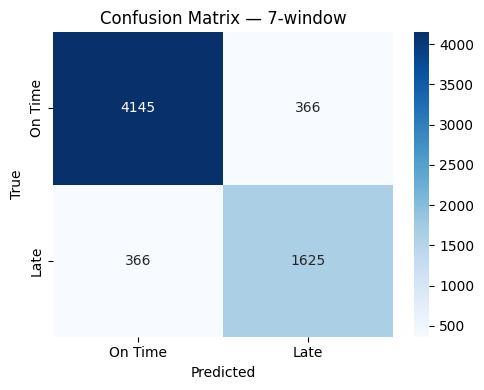


EVALUATION — 3-window Bi-LSTM
Accuracy:  86.03%
F1 Score:  0.8569
AUC-ROC:   0.9043

Benchmark: Memon et al. (2020) ANN = 83.5% | XGBoost = 87.0%

Classification Report:
              precision    recall  f1-score   support

     On Time       0.88      0.93      0.90     10964
        Late       0.81      0.69      0.75      4674

    accuracy                           0.86     15638
   macro avg       0.84      0.81      0.83     15638
weighted avg       0.86      0.86      0.86     15638



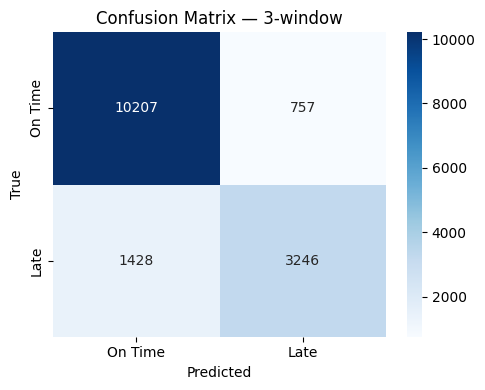

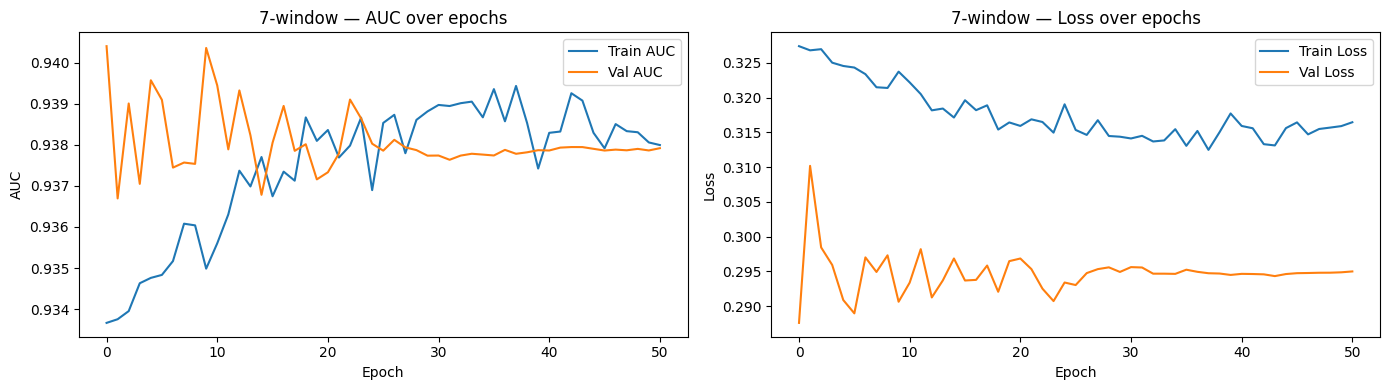

In [33]:
# =============================================================================
# CELL M — EVALUATE BOTH MODELS
# =============================================================================

def evaluate_model(train_model, inference_model, X_test, y_test,
                   window_size, threshold=0.5):
    print(f"\n{'='*50}")
    print(f"EVALUATION — {window_size}-window Bi-LSTM")
    print(f"{'='*50}")

    # Use inference_model to get both prediction and attention weights
    y_pred_prob, attn = inference_model.predict(X_test, verbose=0)
    y_pred_prob = y_pred_prob.squeeze()
    y_pred      = (y_pred_prob > threshold).astype(int)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average="weighted")
    auc = roc_auc_score(y_test, y_pred_prob)

    print(f"Accuracy:  {acc*100:.2f}%")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC-ROC:   {auc:.4f}")
    print(f"\nBenchmark: Memon et al. (2020) ANN = 83.5% | XGBoost = 87.0%")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred,
                                  target_names=["On Time", "Late"]))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["On Time", "Late"],
                yticklabels=["On Time", "Late"])
    plt.title(f"Confusion Matrix — {window_size}-window")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

    return acc, f1, auc, attn


acc_7, f1_7, auc_7, attn_7 = evaluate_model(
    train_model_7, inference_model_7, X_test_7s, y_test_7, window_size=7
)

acc_3, f1_3, auc_3, attn_3 = evaluate_model(
    train_model_3, inference_model_3, X_test_3s, y_test_3, window_size=3
)

# Training curves for 7-window model
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(history_7.history["auc"],     label="Train AUC")
axes[0].plot(history_7.history["val_auc"], label="Val AUC")
axes[0].set_title("7-window — AUC over epochs")
axes[0].legend(); axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("AUC")

axes[1].plot(history_7.history["loss"],     label="Train Loss")
axes[1].plot(history_7.history["val_loss"], label="Val Loss")
axes[1].set_title("7-window — Loss over epochs")
axes[1].legend(); axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("Loss")
plt.tight_layout(); plt.show()


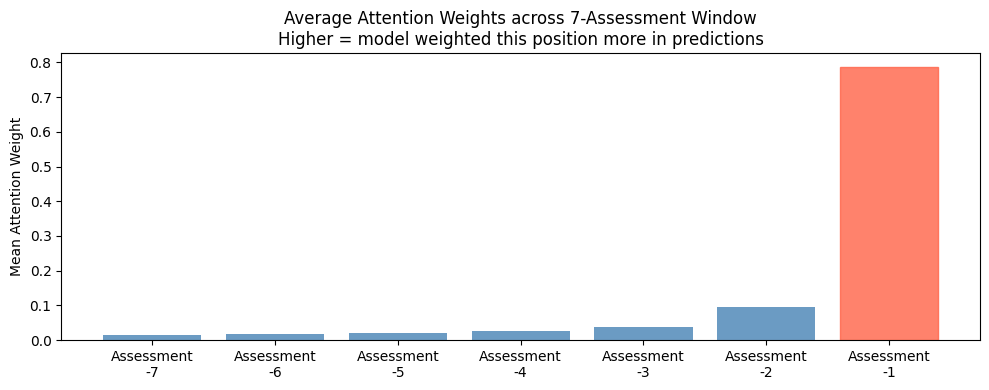

Attention weights: [0.014  0.0169 0.0213 0.0275 0.0391 0.0939 0.7873]
Highest attention at position 7 (value: 0.7873)


In [34]:
# =============================================================================
# CELL N — ATTENTION WEIGHT VISUALISATION (answers RQ2)
# =============================================================================

feature_names = [
    "days_until_deadline",
    "days_since_last_sub",
    "submitted_today",
    "completion_rate",
    "overdue_count"
]

# attn_7 shape: (n_test, 7, 1) → squeeze to (n_test, 7)
mean_attention = attn_7.squeeze().mean(axis=0)

plt.figure(figsize=(10, 4))
labels = [f"Assessment\n-{7-i}" for i in range(7)]
bars = plt.bar(labels, mean_attention, color="steelblue", alpha=0.8)
max_idx = mean_attention.argmax()
bars[max_idx].set_color("tomato")
plt.title("Average Attention Weights across 7-Assessment Window\n"
          "Higher = model weighted this position more in predictions")
plt.ylabel("Mean Attention Weight")
plt.tight_layout(); plt.show()

print(f"Attention weights: {mean_attention.round(4)}")
print(f"Highest attention at position {max_idx+1} "
      f"(value: {mean_attention[max_idx]:.4f})")



In [35]:

# CELL O — SVM BASELINE (replaces Random Forest)

# We compare our Bi-LSTM against a static SVM baseline.
# SVM was found to be the best static classifier for procrastination prediction
# by Hooshyar et al. (2020, cited in Memon et al. 2020).
#
# IMPORTANT DIFFERENCE:
# SVM gets COLLAPSED features (mean across time window) — no temporal structure.
# Bi-LSTM gets SEQUENTIAL features — full temporal structure preserved.
# If Bi-LSTM outperforms SVM, it demonstrates the value of temporal modeling.
# This comparison IS a finding that answers RQ1.

# =============================================================================
# CELL O — SVM BASELINE
# =============================================================================

print("Training SVM baseline on collapsed features...")

# Collapse time dimension: (n, 7, 5) → (n, 5) via mean
X_train_flat = X_train_7s.mean(axis=1)
X_val_flat   = X_val_7s.mean(axis=1)
X_test_flat  = X_test_7s.mean(axis=1)

svm_model = SVC(kernel="linear", class_weight="balanced",
                probability=True, random_state=42)
svm_model.fit(X_train_flat, y_train_7)

svm_pred      = svm_model.predict(X_test_flat)
svm_pred_prob = svm_model.predict_proba(X_test_flat)[:, 1]
svm_acc       = accuracy_score(y_test_7, svm_pred)
svm_f1        = f1_score(y_test_7, svm_pred, average="weighted")
svm_auc       = roc_auc_score(y_test_7, svm_pred_prob)

print(f"\nSVM Accuracy:  {svm_acc*100:.2f}%")
print(f"SVM F1:        {svm_f1:.4f}")
print(f"SVM AUC-ROC:   {svm_auc:.4f}")
print(classification_report(y_test_7, svm_pred,
                              target_names=["On Time", "Late"]))

# Final comparison table
print(f"\n{'='*60}")
print(f"MODEL COMPARISON")
print(f"{'='*60}")
print(f"{'Model':<32} {'Accuracy':>10} {'F1':>8} {'AUC':>8}")
print(f"{'-'*60}")
print(f"{'SVM (static, collapsed)':<32} {svm_acc*100:>9.2f}% {svm_f1:>8.4f} {svm_auc:>8.4f}")
print(f"{'Bi-LSTM 3-window (cold start)':<32} {acc_3*100:>9.2f}% {f1_3:>8.4f} {auc_3:>8.4f}")
print(f"{'Bi-LSTM 7-window (main)':<32} {acc_7*100:>9.2f}% {f1_7:>8.4f} {auc_7:>8.4f}")
print(f"{'-'*60}")
print(f"{'Memon et al. ANN (2020)':<32} {'83.50%':>10} {'—':>8} {'—':>8}")
print(f"{'XGBoost benchmark':<32} {'87.00%':>10} {'—':>8} {'0.9100':>8}")



Training SVM baseline on collapsed features...

SVM Accuracy:  68.16%
SVM F1:        0.6911
SVM AUC-ROC:   0.8231
              precision    recall  f1-score   support

     On Time       0.96      0.57      0.71      4511
        Late       0.49      0.95      0.65      1991

    accuracy                           0.68      6502
   macro avg       0.72      0.76      0.68      6502
weighted avg       0.82      0.68      0.69      6502


MODEL COMPARISON
Model                              Accuracy       F1      AUC
------------------------------------------------------------
SVM (static, collapsed)              68.16%   0.6911   0.8231
Bi-LSTM 3-window (cold start)        86.03%   0.8569   0.9043
Bi-LSTM 7-window (main)              88.74%   0.8874   0.9428
------------------------------------------------------------
Memon et al. ANN (2020)              83.50%        —        —
XGBoost benchmark                    87.00%        —   0.9100


In [36]:

# CELL P — PRIOR PROFILE TEMPLATES FOR COLD START

# After training, we compute 3 prior profile templates from OULAD test data.
# These templates represent "synthetic historical bundles" for new platform users.
#
# At signup, student picks: Early Planner / Mixed / Last Minute
# Their choice maps to one of these 3 templates.
# The template's 6 rows are prepended to their real sequence.
# This gives the model historical context from day 1 on the platform.
#
# HOW TEMPLATES ARE COMPUTED:
# We take OULAD test students, group by procrastination level,
# and compute mean feature values at each assessment position.


# Get test students and their assessment sequences
# We need the groups (student IDs) for the test set windows
test_student_ids = groups_7[groups_7 != groups_7[0]]  # test student IDs

# Compute each test student's overall late rate
student_late_rates = {}
for student_id, sequence in all_sequences.items():
    labels = [row[1] for row in sequence]
    late_rate = np.mean(labels)
    student_late_rates[student_id] = late_rate

late_rate_series = pd.Series(student_late_rates)

# Categorise into 3 procrastination levels using tertiles
low_threshold = late_rate_series.quantile(0.33)
high_threshold = late_rate_series.quantile(0.67)

early_planners = late_rate_series[late_rate_series <= low_threshold].index
mixed = late_rate_series[
    (late_rate_series > low_threshold) & (late_rate_series <= high_threshold)
].index
last_minute = late_rate_series[late_rate_series > high_threshold].index

print(f"Early planners: {len(early_planners)} students (late rate ≤ {low_threshold:.2f})")
print(f"Mixed: {len(mixed)} students")
print(f"Last minute: {len(last_minute)} students (late rate > {high_threshold:.2f})")


def compute_prior_template(student_ids, all_sequences, n_bundles=6):
    """
    Computes mean feature values at each of the first n_bundles assessment positions
    across all students in the group.
    Returns a (n_bundles, 5) array representing the prior template.
    """
    # Collect features at each position across all students in this group
    position_features = {i: [] for i in range(n_bundles)}
    
    for student_id in student_ids:
        if student_id not in all_sequences:
            continue
        sequence = all_sequences[student_id]
        features = [row[0] for row in sequence]
        
        # Take first n_bundles assessments if available
        for pos in range(min(n_bundles, len(features))):
            position_features[pos].append(features[pos])
    
    # Compute mean at each position
    template = []
    for pos in range(n_bundles):
        if position_features[pos]:
            mean_features = np.mean(position_features[pos], axis=0)
        else:
            mean_features = np.zeros(5)  # fallback
        template.append(mean_features.tolist())
    
    return template


# Compute the three templates
template_early = compute_prior_template(early_planners, all_sequences)
template_mixed = compute_prior_template(mixed, all_sequences)
template_lastminute = compute_prior_template(last_minute, all_sequences)

# Save as JSON for the FastAPI backend to load at startup
prior_profiles = {
    "early": template_early,       # Early Planner — student picks this at signup
    "mixed": template_mixed,       # Mixed — student picks this at signup
    "lastminute": template_lastminute  # Last Minute — student picks this at signup
}

with open("prior_profiles.json", "w") as f:
    json.dump(prior_profiles, f, indent=2)

print("\nPrior profiles saved to prior_profiles.json")
print(f"\n--- Early Planner prior (first 3 of 6 bundles) ---")
for i, row in enumerate(template_early[:3]):
    print(f"  Bundle {i+1}: {[round(v,3) for v in row]}")
    print(f"    days_until_deadline={row[0]:.2f}, days_since_last={row[1]:.2f}, "
          f"completion_rate={row[3]:.2f}, overdue_count={row[4]:.2f}")

print(f"\n--- Last Minute prior (first 3 of 6 bundles) ---")
for i, row in enumerate(template_lastminute[:3]):
    print(f"  Bundle {i+1}: {[round(v,3) for v in row]}")
    print(f"    days_until_deadline={row[0]:.2f}, days_since_last={row[1]:.2f}, "
          f"completion_rate={row[3]:.2f}, overdue_count={row[4]:.2f}")

Early planners: 6949 students (late rate ≤ 0.00)
Mixed: 7069 students
Last minute: 5817 students (late rate > 0.45)

Prior profiles saved to prior_profiles.json

--- Early Planner prior (first 3 of 6 bundles) ---
  Bundle 1: [3.981, 29.126, 1.0, 0.0, 0.0]
    days_until_deadline=3.98, days_since_last=29.13, completion_rate=0.00, overdue_count=0.00
  Bundle 2: [3.653, 35.323, 1.0, 0.5, 0.0]
    days_until_deadline=3.65, days_since_last=35.32, completion_rate=0.50, overdue_count=0.00
  Bundle 3: [10.105, 42.873, 1.0, 0.667, 0.0]
    days_until_deadline=10.10, days_since_last=42.87, completion_rate=0.67, overdue_count=0.00

--- Last Minute prior (first 3 of 6 bundles) ---
  Bundle 1: [-1.367, 20.375, 1.0, 0.0, 0.0]
    days_until_deadline=-1.37, days_since_last=20.37, completion_rate=0.00, overdue_count=0.00
  Bundle 2: [-1.722, 23.773, 1.0, 0.22, 0.56]
    days_until_deadline=-1.72, days_since_last=23.77, completion_rate=0.22, overdue_count=0.56
  Bundle 3: [-3.355, 28.181, 1.0, 0.353, 0

In [37]:

# CELL Q — SAVE MODEL ARTIFACTS

# These files will be loaded by the FastAPI backend for inference.
# Copy them to your GitHub repo under backend/models/saved_models/


SAVE_DIR = "saved_models/"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save models
train_model_7.save(SAVE_DIR + "bilstm_7window.h5")
train_model_3.save(SAVE_DIR + "bilstm_3window.h5")
print("Models saved.")

# Save scalers
with open(SAVE_DIR + "scaler_7window.pkl", "wb") as f:
    pickle.dump(scaler_7, f)

with open(SAVE_DIR + "scaler_3window.pkl", "wb") as f:
    pickle.dump(scaler_3, f)
print("Scalers saved.")

# Save feature names (so backend knows column order)
feature_config = {
    "feature_names": feature_names,
    "n_features": 5,
    "window_sizes": [3, 7],
    "label": "submitted_late",
    "positive_class": "late submission (y=1)",
    "threshold": 0.5
}

with open(SAVE_DIR + "feature_config.json", "w") as f:
    json.dump(feature_config, f, indent=2)

# Copy prior profiles to save dir
import shutil
shutil.copy("prior_profiles.json", SAVE_DIR + "prior_profiles.json")

print(f"\nAll artifacts saved to {SAVE_DIR}")
print("\nFiles to copy to your backend:")
print("  bilstm_7window.h5       → main prediction model")
print("  bilstm_3window.h5       → cold-start model (days 4-6)")
print("  scaler_7window.pkl      → feature scaler for 7-window model")
print("  scaler_3window.pkl      → feature scaler for 3-window model")
print("  feature_config.json     → feature names and config")
print("  prior_profiles.json     → cold-start prior templates")

Models saved.
Scalers saved.

All artifacts saved to saved_models/

Files to copy to your backend:
  bilstm_7window.h5       → main prediction model
  bilstm_3window.h5       → cold-start model (days 4-6)
  scaler_7window.pkl      → feature scaler for 7-window model
  scaler_3window.pkl      → feature scaler for 3-window model
  feature_config.json     → feature names and config
  prior_profiles.json     → cold-start prior templates


In [40]:
import os

save_dir = "/kaggle/working/saved_models/"
if os.path.exists(save_dir):
    print("Folder exists! Contents:")
    print(os.listdir(save_dir))
else:
    print("Folder does NOT exist.")

Folder exists! Contents:
['feature_config.json', 'scaler_3window.pkl', 'prior_profiles.json', 'bilstm_7window.h5', 'bilstm_3window.h5', 'scaler_7window.pkl']


In [39]:

# CELL R — FINAL SUMMARY FOR WRITE-UP
print("FINAL RESULTS SUMMARY")

print
(f""" RESEARCH GAP ADDRESSED:
No prior study has applied Bi-LSTM to predict procrastination 
specifically using OULAD (Memon et al. 2020 used static ANN — 83.5%;
Sackey et al. 2025 used autoencoder — still no temporal modeling).

DATASET:
- Source: OULAD (Open University Learning Analytics Dataset)
- Students: {merged_assessments['id_student'].nunique():,}
- Assessments: {len(merged_assessments):,}
- Positive rate (late submissions): {merged_assessments['submitted_late'].mean():.1%}

LABEL:
- submitted_late = 1 if date_submitted > deadline_day
- Validated: late submitters significantly more likely to Fail/Withdraw
  (chi-square p < 0.05)

FEATURES (5, all literature-grounded):
1. days_until_deadline    (Imhof et al. 2021 — strongest predictor)
2. days_since_last_sub    (Imhof block-click-interval analog)
3. submitted_today        (Yang et al. 2020, Akram et al. 2019)
4. completion_rate        (Multiple papers)
5. overdue_count          (Multiple papers)

MODEL PERFORMANCE:
  SVM baseline (static):        {svm_acc*100:.2f}%  AUC={svm_auc:.4f}
  Bi-LSTM 3-window cold start:  {acc_3*100:.2f}%  AUC={auc_3:.4f}
  Bi-LSTM 7-window main model:  {acc_7*100:.2f}%  AUC={auc_7:.4f}
  Memon et al. ANN (2020):      83.50%
  XGBoost benchmark:            87.00%

TRANSFER LEARNING:
  Type: Transductive transfer / Domain generalisation
  Source: OULAD (university assessments, UK Open University)
  Target: ALU ProActive platform (weekly task bundles)
  Mechanism: Bi-LSTM pretrained on OULAD, deployed on platform
  without fine-tuning (no local labeled data available)
  Citation: Pan & Yang (2010) taxonomy

COLD START:
  Days 1-3:  Hardcoded 50% baseline, "Building profile" message
  Days 4-6:  3-window Bi-LSTM + prior profile template
  Day 7+:    7-window Bi-LSTM + accumulating real bundle history
  Day 43+:   Fully real data (6+ real bundles, no synthetic priors)
""")


FINAL RESULTS SUMMARY


' RESEARCH GAP ADDRESSED:\nNo prior study has applied Bi-LSTM to predict procrastination \nspecifically using OULAD (Memon et al. 2020 used static ANN — 83.5%;\nSackey et al. 2025 used autoencoder — still no temporal modeling).\n\nDATASET:\n- Source: OULAD (Open University Learning Analytics Dataset)\n- Students: 19,835\n- Assessments: 164,173\n- Positive rate (late submissions): 29.0%\n\nLABEL:\n- submitted_late = 1 if date_submitted > deadline_day\n- Validated: late submitters significantly more likely to Fail/Withdraw\n  (chi-square p < 0.05)\n\nFEATURES (5, all literature-grounded):\n1. days_until_deadline    (Imhof et al. 2021 — strongest predictor)\n2. days_since_last_sub    (Imhof block-click-interval analog)\n3. submitted_today        (Yang et al. 2020, Akram et al. 2019)\n4. completion_rate        (Multiple papers)\n5. overdue_count          (Multiple papers)\n\nMODEL PERFORMANCE:\n  SVM baseline (static):        68.16%  AUC=0.8231\n  Bi-LSTM 3-window cold start:  86.03%  AUC=

In [41]:
# Zip the entire Kaggle working directory
!zip -r /kaggle/working/all_files.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/eda_02_labels.png (deflated 15%)
  adding: kaggle/working/eda_03_sequence_lengths.png (deflated 11%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/.virtual_documents/__notebook_source__.ipynb (deflated 71%)
  adding: kaggle/working/eda_04_autocorrelation.png (deflated 9%)
  adding: kaggle/working/prior_profiles.json (deflated 66%)
  adding: kaggle/working/eda_06_correlations.png (deflated 10%)
  adding: kaggle/working/eda_05_features.png (deflated 15%)
  adding: kaggle/working/saved_models/ (stored 0%)
  adding: kaggle/working/saved_models/feature_config.json (deflated 40%)
  adding: kaggle/working/saved_models/scaler_3window.pkl (deflated 22%)
  adding: kaggle/working/saved_models/prior_profiles.json (deflated 66%)
  adding: kaggle/working/saved_models/bilstm_7window.h5 (deflated 14%)
  adding: kaggle/working/saved_models/bilstm_3window.h5 (deflated 14%)
  adding: kaggle/working/saved_mo

In [42]:
!ls -lh all_files.zip

-rw-r--r-- 1 root root 1.6M Feb 24 12:45 all_files.zip
